# 이미지 분석 AI기반 폐렴 분석 및 예측 모델 개발

## Library Build

In [278]:
# chest_xray 디렉토리 밑에 train, test, val 디렉토리 존재, 약 3670개 사진
import matplotlib.pyplot as plt
import numpy as np
import PIL # 여럭 각도에서 사이즈를 조절
import tensorflow as tf
from tensorflow.keras import layers # type: ignore
import os
import pathlib # 경로 url을 객체화 하여 속성 사용 가능
import urllib.request # url의 내용을 가져오는 기능
import tarfile # 서버의 데이터를 압축 및 압축 풀기 기능
import streamlit as st
from PIL import Image

: 

## Data Load

In [255]:
# 데이터 경로 설정
xray_data=pathlib.Path("../dataset/chest_xray")

# 클래스 및 이미지 개수 확인
classes = sorted([item.name for item in xray_data.glob("*/") if item.is_dir()]) # glob : 하위 디렉토리의 파일 갯수를 확인하기위한 method
image_count = len(list(xray_data.glob("*/*.jpeg")))
print(f"발견된 클래스: {classes}")
print(f"총 이미지 개수: {image_count}")

# 각 클래스별 이미지 개수 확인
for class_name in classes:
    class_images = len(list(xray_data.glob(f"{class_name}/*")))
    print(f"{class_name}: {class_images}개 이미지")

발견된 클래스: ['NORMAL', 'PNEUMONIA']
총 이미지 개수: 5856
NORMAL: 1584개 이미지
PNEUMONIA: 4274개 이미지


## 데이터 이미지 전처리

In [256]:
# 이미지 크기 및 배치 크기 설정
img_height = 1000
img_width = 1000
batch_size = 32

In [257]:
# 훈련 데이터셋 생성
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    str(xray_data),
    validation_split=0.2,
    subset="training", # train data
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 5856 files belonging to 2 classes.
Using 4685 files for training.


In [258]:
# 검증 데이터셋 생성
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    str(xray_data),
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 5856 files belonging to 2 classes.
Using 1171 files for validation.


In [259]:
# 클래스 이름 확인
class_names=train_ds.class_names
print("클래스:", class_names)
num_classes=len(class_names)

클래스: ['NORMAL', 'PNEUMONIA']


In [260]:
# 데이터셋 성능 최적화(이미지 파일 용량이 커 캐시에 저장해두고 필요할때 불러서 사용하는 방식)
AUTOTUNE=tf.data.AUTOTUNE
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds=val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [261]:
# 데이터 증강 레이어 정의
data_augmentation=tf.keras.Sequential([
    layers.RandomFlip("horizontal"), # 학습을 위해 이미지를 회전(180도 회전)
    layers.RandomRotation(0.2), # 20도 회전
    layers.RandomZoom(0.2) # 20% 확대
])

2025-01-14 13:56:46.702880: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:774: Filling up shuffle buffer (this may take a while): 140 of 1000
2025-01-14 13:56:47.364249: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-01-14 13:56:47.472068: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


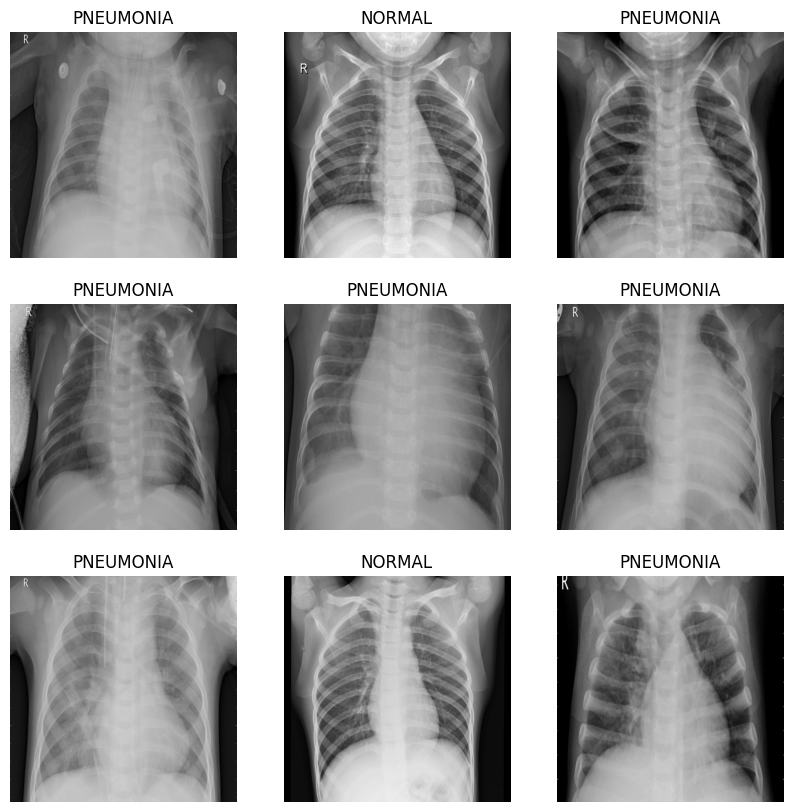

In [262]:
# 샘플 이미지 시각화
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

## 학습 모델 구성

In [263]:
# CNN 모델 구성
model = tf.keras.Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

In [264]:
# 모델 컴파일
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), # 다중 클래스 특화, 각 클래스별 확률 예측
    metrics=["accuracy"]
)

In [265]:
# 모델 구조 출력
model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_12 (Sequential)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_6 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [266]:
# Earyl stopping 콜백 설정
callbacks =  [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True
    )
]

## 모델 학습

In [267]:
# # 모델 학습
# epochs = 15
# history = model.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=epochs,
#     callbacks=callbacks
# )

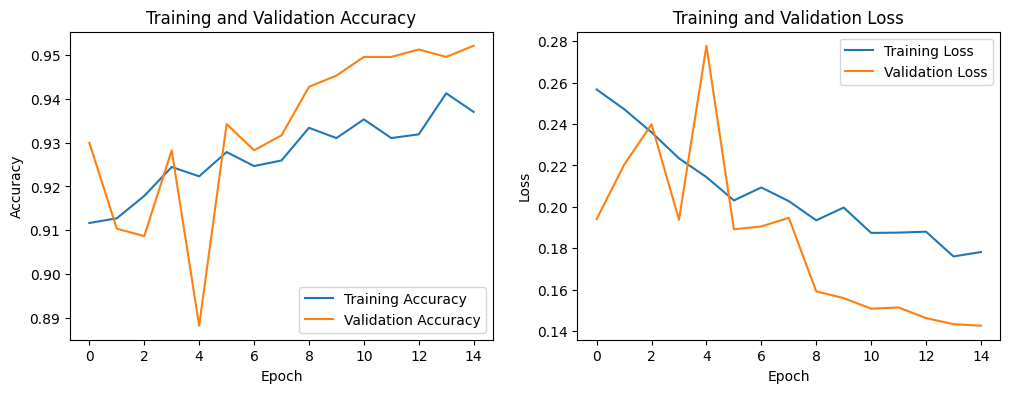

In [ ]:
# # 학습 결과 시각화
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs_range = range(len(acc))

# plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend(loc='lower right')

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend(loc='upper right')
# plt.show()

## 학습 모델 저장

In [269]:
# # 모델 저장
# model.save('../model/chest_xray_model_500x500.h5')
# print("모델이 'chest_xray_model.h5'로 저장되었습니다.")

모델이 'chest_xray_model.h5'로 저장되었습니다.


In [270]:
# 저장된 모델 불러오기
from tensorflow.keras.models import load_model # type: ignore

In [275]:
model_path = '../model/chest_xray_model_1000x1000_v02.h5'  # 저장된 모델 경로
loaded_model = load_model(model_path)
print("저장된 모델이 성공적으로 로드되었습니다.")

저장된 모델이 성공적으로 로드되었습니다.


## 학습된 모델을 통한 이미지 분석

In [276]:
# 저장된 모델을 활용한 이미지 예측 함수
def predict_pneumonia(img_path, model, class_names): 
    """
    이미지 경로와 모델을 입력받아 예측 결과를 출력하고 이미지를 시각화 하는 함수.
    
    Parameters:
        img_path(str): 예측할 이미지 파일 경로.
        model(tf.keras.Model): 저장된 모델.
        class_names(list): 클래스 이름 리스트.
    """

    # 이미지 로드 및 전처리
    img=tf.keras.preprocessing.image.load_img(
        img_path, target_size=(img_height, img_width)
    )
    img_array=tf.keras.preprocessing.image.img_to_array(img)
    img_array=tf.expand_dims(img_array, 0) # 배치 차원 추가

    # 예측 수행
    predictions=model.predict(img_array)
    score=tf.nn.softmax(predictions[0])

    # 예측 결과 출력
    print(
        "이 이미지는 '{}' ({:.2f}% 확률) 입니다."
        .format(class_names[np.argmax(score)], 100*np.max(score))
    )

    # 이미지 시각화
    plt.imshow(img)
    plt.axis("off")
    plt.show()


In [277]:
loss, accuracy = loaded_model.evaluate(val_ds, verbose=1)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9185 - loss: 0.2103
Test Loss: 0.18016165494918823
Test Accuracy: 0.9350982308387756


In [ ]:
# 1. 이미지 업로드
test_image_path = st.file_uploader("Upload an image", type=["jpg", "jpeg", "png"])

if test_image_path is not None:
    # 2. Pillow로 이미지 열기
    image = Image.open(test_image_path)

    # 3. 이미지 출력
    st.image(image, caption="Uploaded Image", use_column_width=True)

    # 4. 이미지 크기 출력
    st.write(f"Image size: {image.size} (width, height)")


In [212]:
# 테스트 이미지 경로
# test_image_path = '../dataset/chest_xray/PNEUMONIA/person1_bacteria_1.jpeg'
# test_image_path = '../dataset/test07.png'
# test_image_path = '../dataset/chest_xray/PNEUMONIA/person20_bacteria_67.jpeg'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
이 이미지는 'NORMAL' (70.89% 확률) 입니다.


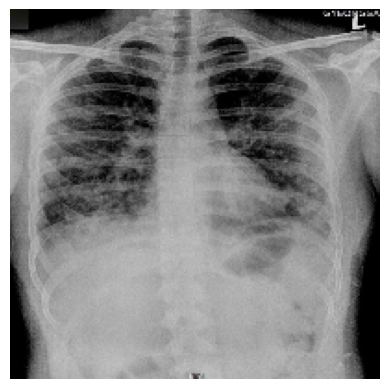

In [ ]:
# 예측 실행
# 버튼 생성
if st.button("진단하기"):
    st.write(f"진단 결과 : {predict_pneumonia(test_image_path, loaded_model, class_names)}")